# 1.Load data

In [82]:
import pandas as pd

In [83]:
data = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape')
#Display first 10 rows
data.head(10)

,Sentence #,Word,POS,Tag
0,0.0,TTC,NN,O
1,NaN,"640,00",CD,B-ttc
2,1.0,TOTAL,NN,O
3,NaN,PAYEE,NN,O
4,NaN,"640,00",CD,B-ttc
5,NaN,sad,NN,O
6,2.0,Total,JJ,O
7,NaN,"130,00",CD,B-ttc
8,NaN,MAD,NN,O
9,3.0,Sous,JJ,O


In [84]:
data.describe()

,Sentence #
count,342.000000
mean,170.500000
std,98.871128
min,0.000000
25%,85.250000
50%,170.500000
75%,255.750000
max,341.000000


In [85]:
#Displaying the unique Tags
data['Tag'].unique()

array(['O', 'B-ttc', 'I-ttc'], dtype=object)

In [86]:
#Checking null values, if any.
data.isnull().sum()

Sentence #    1122
Word             0
POS              0
Tag              0
dtype: int64

In [87]:
#Display data shape
data.shape

(1464, 4)

## 2. Extract mappings required for the neural network
To train a neural network, we will use two mappings as given below. The neural network will only take integers as input. So lets convert all the unique tokens in the corpus to its respective index.
- {token} to {token id}: address the row in embeddings matrix for the current token.
- {tag} to {tag id}: one-hot ground truth probability distribution vectors for computing the loss at the output of the network.

In [88]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [89]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx) 

In [90]:
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,0.0,TTC,NN,O,211,2
1,NaN,"640,00",CD,B-ttc,95,1
2,1.0,TOTAL,NN,O,112,2
3,NaN,PAYEE,NN,O,22,2
4,NaN,"640,00",CD,B-ttc,95,1


## 3. Transform columns to extract sequential data
Next, lets fill NaN in 'sentence #' column using method ffill in fillna. Thereafter groupby on the sentence column to get a list of tokens and tags for each sentence.

In [91]:
data.isna().any()

Sentence #     True
Word          False
POS           False
Tag           False
Word_idx      False
Tag_idx       False
dtype: bool

In [92]:
data_fillna = data.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(['Sentence #'],as_index=False
                                )['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

data_group.head()

C:\Users\brahi\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,0.0,"[TTC, 640,00]","[NN, CD]","[O, B-ttc]","[211, 95]","[2, 1]"
1,1.0,"[TOTAL, PAYEE, 640,00, sad]","[NN, NN, CD, NN]","[O, O, B-ttc, O]","[112, 22, 95, 81]","[2, 2, 1, 2]"
2,2.0,"[Total, 130,00, MAD]","[JJ, CD, NN]","[O, B-ttc, O]","[83, 196, 10]","[2, 1, 2]"
3,3.0,"[Sous, Total, 108,33, MAD, TVA, 21,67, MAD, To...","[JJ, JJ, CD, NN, NN, CD, NN, JJ, CD, NN]","[O, O, O, O, O, O, O, O, B-ttc, O]","[71, 83, 189, 10, 33, 60, 10, 83, 196, 10]","[2, 2, 2, 2, 2, 2, 2, 2, 1, 2]"
4,4.0,"[TOTAL, FACTURE, DIRHAMS, TTC, 350,00]","[NN, NN, NN, NN, CD]","[O, O, O, I-ttc, B-ttc]","[112, 111, 105, 211, 29]","[2, 2, 2, 0, 1]"


## 4. Pad sequences and split the dataset into train, test
Padding: The LSTM layers accept sequences of same length only. Therefore we will want to transform our list of token_sequences ('Word_idx') which is lists of integers into a matrix of shape (token_sequences, max_len). We can use any length as max_len. In this project we will be using length of the longest sequence as max_len. The sequences that are shorter than max_len are padded with a specified value at the end.
Import required packages

In [93]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import keras
from keras.utils import to_categorical

In [94]:
def get_pad_train_test_val(data_group, data):
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))
    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)
    
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    
    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ntest_tags:', len(test_tags)
    )
    
    return pad_tokens, pad_tags

train_tokens, train_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 307 
test_tokens length: 35 
train_tags: 307 
test_tags: 35


In [95]:
for token, tag in zip(train_tokens[0], train_tags[0]):
    print('%s\t%s' % (token, tag))

211	[0. 0. 1.]
95	[0. 1. 0.]
233	[0. 0. 1.]
233	[0. 0. 1.]
233	[0. 0. 1.]
233	[0. 0. 1.]
233	[0. 0. 1.]
233	[0. 0. 1.]
233	[0. 0. 1.]
233	[0. 0. 1.]
233	[0. 0. 1.]


## 5. Build Model Layout

Lets go through the process of building a neural network model with lstm layers. Please compare the layers brief and model plot given below to get a better understanding of the layers, input and output dimensions. We are building a simple model with 4 layers.

- **Layer 1 - Embedding layer** : We will feed the padded sequences of equal length (104) to the embedding layer. Once the network has been trained, each token will get transformed into a vector of n dimensions. We have chosen the n dimensions to be (64). 


These are the dimensions (?, 104, 64) plotted in the model plot for input layer and embedding layer. The ? or None in the dimension specifies batches, when it is None or ? the model can take any batch size.

- **Layer 2 - Bidirectional LSTM** : Bidirectional lstm takes a recurrent layer (e.g. the first LSTM layer) as an argument. This layer takes the output from the previous embedding layer (104, 64). It also allows you to specify the merge mode, that is how the forward and backward outputs should be combined before being passed on to the next layer. The default mode is to concatenate, where the outputs are concatenated together, providing double the number of outputs to the next layer, in our case its 128(64 * 2).


The output dimension of the bidirectional lstm layer (?, 104, 128) becomes the input dimension of the next lstm layer.

- **Layer 3 - LSTM Layer** : An LSTM network is a recurrent neural network that has LSTM cell blocks in place of our standard neural network layers. These cells have various components called the input gate, the forget gate and the output gate.


This layer takes the output dimension from the previous bidirectional lstm layer (?, 104, 128) and outputs (?, 104, 256)



- **Layer 4 - TimeDistributed  Layer** : We are dealing with Many to Many RNN Architecture where we expect output from every input sequence for example (a1 →b1, a2 →b2… an →bn) where a and b are inputs and outputs of every sequence. The TimeDistributeDense layers allow you to apply Dense(fully-connected) operation across every output over every time-step. If you don't use this, you would only have one final output.



This layer take the output dimension of the previous lstm layer (104, 256) and outputs the max sequence length (104) and max tags (17).

In [96]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
# import keras as k

In [97]:
from numpy.random import seed
tensorflow.random.set_random_seed(1)
tensorflow.random.set_random_seed(2)


In [98]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 32
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  235 
output_dim:  32 
input_length:  11 
n_tags:  3


In [99]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    myOptimizer = tensorflow.keras.optimizers.RMSprop()
    model.compile(loss='mean_squared_error', optimizer=myOptimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [119]:
# Number of data points passed in each iteration
batch_size = 64
# Passes through entire dataset
epochs = 45

In [101]:
checkpointer = ModelCheckpoint(filepath = 'model.h5',verbose = 0,mode = 'auto',save_best_only = True,monitor='val_loss')

In [120]:
def train_model(X, y, model):
    loss = list()
    for _ in range(epochs):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=batch_size, verbose=1, epochs=1, validation_split=0.1, callbacks=[checkpointer])
        loss.append(hist.history['loss'][0])
    return loss
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 11, 32)            7520      
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 11, 64)            16640     
_________________________________________________________________
lstm_39 (LSTM)               (None, 11, 32)            12416     
_________________________________________________________________
time_distributed_19 (TimeDis (None, 11, 3)             99        
Total params: 36,675
Trainable params: 36,675
Non-trainable params: 0
_________________________________________________________________
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [121]:
results = pd.DataFrame()
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

Train on 307 samples, validate on 35 samples
307/307 [==============================] - 10s 32ms/sample - loss: 0.2730 - acc: 0.7329 - val_loss: 0.1688 - val_acc: 0.8416
Train on 307 samples, validate on 35 samples
307/307 [==============================] - 0s 1ms/sample - loss: 0.1278 - acc: 0.8804 - val_loss: 0.1029 - val_acc: 0.8416
Train on 307 samples, validate on 35 samples
307/307 [==============================] - 0s 1ms/sample - loss: 0.0983 - acc: 0.8804 - val_loss: 0.0973 - val_acc: 0.8416
Train on 307 samples, validate on 35 samples
307/307 [==============================] - 0s 1ms/sample - loss: 0.0902 - acc: 0.8804 - val_loss: 0.0952 - val_acc: 0.8416
Train on 307 samples, validate on 35 samples
307/307 [==============================] - 0s 1ms/sample - loss: 0.0893 - acc: 0.8804 - val_loss: 0.0938 - val_acc: 0.8416
Train on 307 samples, validate on 35 samples
307/307 [==============================] - 0s 1ms/sample - loss: 0.0848 - acc: 0.8804 - val_loss: 0.0931 - val_ac

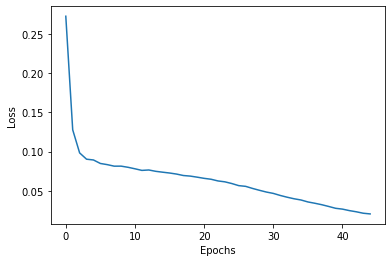

In [122]:
import matplotlib.pyplot as plt
plt.plot(results['with_add_lstm'])
plt.xlabel('Epochs');
plt.ylabel('Loss');

Model started with 0.7329 accuracy and 0.8416 val_accuracy . After running 45 epochs with 64 batch size, the final accuracy was 0.9692 and 0.8987 val_accuracy.

## Evaluating the model on test set

In [ ]:
X_test , y_test

In [ ]:

# Evaluation
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [ ]:
# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true]

In [ ]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

In [ ]:
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

In [ ]:
# At every execution model picks some random test sample from test set.
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_te)b
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))